In [1]:
import sys
from pathlib import Path

import h5py as h5
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append('../lib')
from local_paths import analysis_dir, mplstyle_path
from summary_utils import verified_update, annotate_unit_df, select_units, summarize_results_per_region
from plot_utils import plot_region_tests, annotate_per_region_axes

In [2]:
plt.style.use(mplstyle_path)

# Parameters

In [3]:
analysis_name = 'face_specific'
results_dir = analysis_dir + analysis_name

# analysis-specific conditions
norm_an = 'psth2-all_saccades'  # analysis for response normalization
psth1_conds = ('Nonface', 'Face')
psth1_cond_palette = dict(zip(psth1_conds, ('tab:blue', 'tab:orange')))
psth2_conds = ('Nonface, nonface', 'Nonface, face', 'Face, nonface', 'Face, face')
psth2_cond_palette = dict(zip(psth2_conds, plt.get_cmap('tab20')([.05, .1, 0, .15])))
sacc_conds = ('all', 'large')
sacc_cond_main = 'all'

# unit selection
unit_sel_path = 'unit_sel/face_selective.csv.gz'
subjs = ('Pa', 'Bo', 'Re')
subj_labels = ('M1 (CIT)', 'M2 (AIT)', 'M3 (AIT)')

# statistics
spread_type = 'mad'  # for PSTHs; unlike in most other analyses, this spread is across neurons
psth1_stat_tests = None  # (('Face', 'Nonface', 'greater'),)
psth2_stat_tests = (
    ('Nonface, face', 'Nonface, nonface', 'greater'),
    ('Face, face', 'Face, nonface', 'greater'))

# Load data

In [4]:
unit_df = {'Session': [], 'Unit': []}
results = {k: [] for k in (
    'psth1-fix0', 'psth1-fix1+',
    *(f'psth2-{c}_saccades' for c in sacc_conds))}
coords = {}

results_dir = Path(results_dir).expanduser()
for fp in results_dir.glob('*.h5'):
    with h5.File(fp, 'r') as f:
        try:
            assert f[f'progress_report/{analysis_name}/all_done'][()]
            group1 = f[analysis_name+'/by_fixation/psth']
            group2 = f[analysis_name+'/by_saccade/by_saccade_size']
        except (KeyError, AssertionError):
            continue

        coords_ = {}

        # fixation-aligned PSTHs
        verified_update(coords, dict(time=group1['time'][()]))
        verified_update(coords_, dict(unit=group1['unit'][()]))
        v = group1['data'][:,:,0,:,:]
        results['psth1-fix0'].append(v[0])
        results['psth1-fix1+'].append(v[1])

        # saccade-aligned PSTHs
        for scond in sacc_conds:
            group = group2[scond]['psth']
            verified_update(coords_, dict(unit=group['unit'][()]))
            for c in ('time', 'fix1_category', 'fix2_category'):
                verified_update(coords, {c: group[c][()]})
            v = group['data'][:,:,0,:,:]
            results[f'psth2-{scond}_saccades'].append(v.reshape(-1, *v.shape[-2:]))

    unit_names = coords_['unit'].astype(str)
    unit_df['Session'].append(np.full(unit_names.size, fp.stem))
    unit_df['Unit'].append(unit_names)

print('coordinates:')
for k, v in coords.items():
    print('\t', k, v.shape, v.dtype)
print('results:')
for d in (results, unit_df):
    for k, v in d.items():
        d[k] = v = np.concatenate(v, axis=-1)
        print('', f'{k:<20s}', v.shape, v.dtype, sep='\t')
print(np.unique(unit_df['Session']).size, 'sessions')
unit_df = annotate_unit_df(pd.DataFrame(unit_df))

coordinates:
	 time (76,) float64
	 fix1_category (2,) object
	 fix2_category (2,) object
results:
	psth1-fix0          	(2, 76, 13264)	float32
	psth1-fix1+         	(2, 76, 13264)	float32
	psth2-all_saccades  	(4, 76, 13264)	float32
	psth2-large_saccades	(4, 76, 13264)	float32
	Session             	(13264,)	<U10
	Unit                	(13264,)	<U3
128 sessions


# Select units

In [5]:
m = results[norm_an]
m = m.reshape(-1, m.shape[-1]).ptp(0) > 0

unit_df, unit_sel, regions = select_units(
    unit_df,
    selection_path=unit_sel_path,
    select_valid_values=m)

for k, v in results.items():
    results[k] = v[..., unit_sel]
unit_df.reset_index()[['Session','Unit']].to_csv('unit_sel/fig2ce.csv.gz', index=False)

> Selected units: n = 2683 of 13264 (20.2% of data, 100.0% of selection) based on face_selective.csv.gz
> Selected units: n = 2630 of 2683 (98.0%) with valid values
> No rare subject to exclude
	 min norm. units per region: Region
	AIT    0.815657
	CIT    1.000000
	Name: Norm. units, dtype: float64


# Normalize PSTHs

Normalize per unit to its response range across conditions x timepoints in `norm_an`

In [6]:
norm = results[norm_an]  # shape (ncond, nt, nu)
norm = norm.reshape(-1, norm.shape[-1])
norm = np.array([norm.min(0), norm.max(0)])  # shape (2, nu)
assert np.all(norm.ptp(0) > 0)  # sanity check for unit selection

norm_results = {}
for k, v in results.items():
    norm_results[k] = (v - norm[0]) / norm.ptp(0)

# Summarize results per subject

In [7]:
# since spread is across units, makes little sense to do sem or ci_of_mean
# thus, mad calculation (below) is hard-coded
assert spread_type == 'mad'

# hack to use two-level summary code (designed to pool first per subject, then per region)
# to do one-level summary
unit_df['Subject_'] = unit_df['Subject']

byresult_summary = {}
for k, v in norm_results.items():
    i = 'psth2' in k
    kws = dict(
        conds=(psth1_conds, psth2_conds)[i],
        stat_tests=(psth1_stat_tests, psth2_stat_tests)[i])
    byresult_summary[k] = summarize_results_per_region(
        unit_df=unit_df,
        result_vals=v,
        spread_type='ci_of_median',  # calculate center as median; ci unused; spread calculated separately below
        level1='Subject',
        level2='Subject_',
        n_bootstraps=0,
        **kws)

# Fixation-aligned PSTHs

In [8]:
def mad(a, axis=-1):
    m = np.nanmedian(a, axis=axis, keepdims=True)
    return np.nanmedian(np.abs(a-m), axis=axis)

center/spread estimate: mad


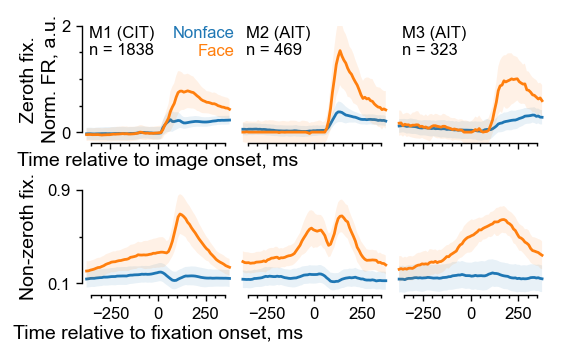

In [9]:
conds = psth1_conds
cond_palette = psth1_cond_palette
ts = coords['time']

fig, axs = plt.subplots(2, len(subjs), figsize=(len(subjs),1.75), sharex=True)
plt.subplots_adjust(wspace=0.025, hspace=0.3)

for ifix, axs_ in enumerate(axs):
    summary = byresult_summary['psth1-fix' + ('0', '1+')[ifix]]

    for isubj, (subj, ax) in enumerate(zip(subjs, axs_)):
        m, bs = summary['one-level_center_boots'][subj]

        for icond, cond in enumerate(conds):
            color = cond_palette[cond]
            ax.plot(ts, m[icond], color=color, zorder=2+icond/4)
            s = mad(summary['two-level_vals'][subj][subj][icond])
            spread = (m[icond]-s, m[icond]+s)
            ax.fill_between(ts, *spread, ec='none', fc=color, alpha=0.1, zorder=1.9+icond/4)

xlim = (-400, 400)
xtks = (-250, 0, 250)
xmtks = np.arange(-350, 351, 50)
for ax in axs.ravel():
    ax.set_xlim(xlim)
    ax.set_xticks(xtks)
    ax.set_xticks(xmtks, minor=True)
    ax.spines['bottom'].set_bounds(xmtks.min(), xmtks.max())
axs[0, 0].set_xlabel('Time relative to image onset, ms')
axs[1, 0].set_xlabel('Time relative to fixation onset, ms')

for ifix, axs_ in enumerate(axs):
    if ifix:
        ybound = (.1, .9)
        ylim = (0, 1)
        ymtks = (.5,)
    else:
        ybound = (0, 2)
        ylim = (-.2, 2)
        ymtks = (.5, 1, 1.5)
    for i, ax in enumerate(axs_):
        ax.set_ylim(ylim)
        if i:
            ax.set_yticks([])
            ax.spines['left'].set_visible(False)
        else:
            ax.set_yticks(ybound)
            ax.set_yticklabels(list(map(str, ybound)))
            ax.set_yticks(ymtks, minor=True)
            ax.spines['left'].set_bounds(ybound)
            tform = mpl.transforms.blended_transform_factory(ax.transAxes, ax.transData)
            if ifix == 0:
                ax.set_ylabel('Zeroth fix.\nNorm. FR, a.u.')
                ax.yaxis.set_label_coords(-.15, np.mean(ybound), transform=tform)
            else:
                ax.set_ylabel('Non-zeroth fix.')
                ax.yaxis.set_label_coords(-.2875, np.mean(ybound), transform=tform)

annotate_per_region_axes(
    axs[0],
    subjs,
    ns_per_region=summary['two-level_nunit'],
    conds=conds,
    palette=cond_palette,
    region_labels=subj_labels,
    show_num_subj=False,
    h=1,
    d=.15)

print('center/spread estimate:', spread_type)

plt.savefig('plots/fig2c.png')

# Saccade-aligned PSTHs

center/spread estimate: mad


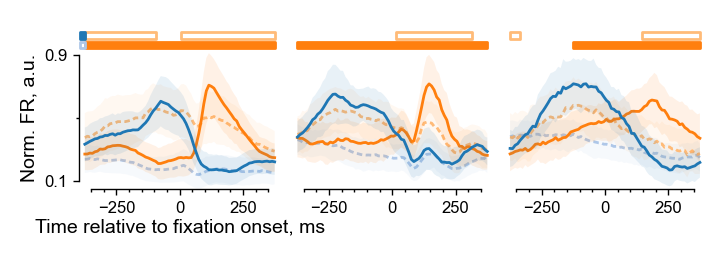

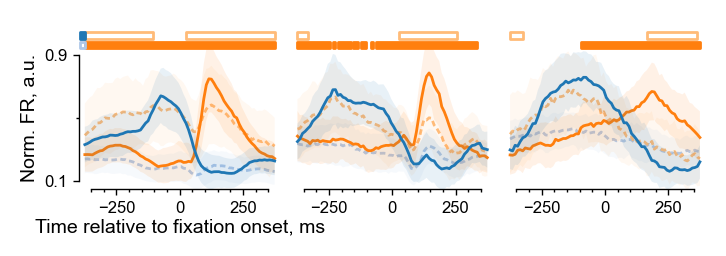

In [10]:
conds = psth2_conds
cond_palette = psth2_cond_palette
cond_z = (0, 2, 3, 1)
cond_open = {c: len({v.lower() for v in c.split(', ')}) == 1 for c in conds}
ts = coords['time']

for scond in sacc_conds:
    summary = byresult_summary[f'psth2-{scond}_saccades']

    fig, axs = plt.subplots(1, len(subjs), figsize=(1.35*len(subjs),1.1), sharex=True)
    plt.subplots_adjust(wspace=0.05)

    for isubj, (subj, ax) in enumerate(zip(subjs, axs)):
        m, bs = summary['one-level_center_boots'][subj]

        for icond, cond in enumerate(conds):
            color = cond_palette[cond]
            zo = cond_z[icond]
            ls = ('-', '--')[icond in (0,3)]

            ax.plot(ts, m[icond], color=color, ls=ls, zorder=2+zo/4)
            s = mad(summary['two-level_vals'][subj][subj][icond])
            spread = (m[icond]-s, m[icond]+s)
            ax.fill_between(ts, *spread, ec='none', fc=color, alpha=0.1, zorder=1.9+zo/4)

    ybound = (.1, .9)
    ymax = plot_region_tests(
        xs=ts, axs=axs, regions=subjs,
        summary=summary,  palette=cond_palette, ybound=ybound,
        indicate_null=True, cond_open=cond_open,
        xfrac=2, yskip=0.5, ec=True)

    xlim = (-400, 400)
    xtks = (-250, 0, 250)
    xmtks = np.arange(-350, 351, 50)
    ylim = (0.05, ymax)
    ymtks = (.5,)
    for col, ax in enumerate(axs):
        ax.set_xlim(xlim)
        ax.set_xticks(xtks)
        ax.set_xticks(xmtks, minor=True)
        ax.spines['bottom'].set_bounds(xmtks.min(), xmtks.max())
        ax.set_ylim(ylim)
        if col:
            ax.set_yticks([])
            ax.spines['left'].set_visible(False)
        else:
            ax.set_yticks(ybound, list(map(str, ybound)))
            ax.set_yticks(ymtks, minor=True)
            ax.spines['left'].set_bounds(ybound)

    ax = axs[0]
    ax.set_xlabel('Time relative to fixation onset, ms')
    ax.set_ylabel('Norm. FR, a.u.')
    tform = mpl.transforms.blended_transform_factory(ax.transAxes, ax.transData)
    ax.yaxis.set_label_coords(-.2, np.mean(ybound), transform=tform)

    if scond == sacc_cond_main:
        plt.savefig('plots/fig2e.png')
    else:
        plt.savefig('plots/figx1.png')

print('center/spread estimate:', spread_type)